# Scenario: 
#### You work with a data science company that creates data science content (books, online articles, videos, interactive text-based platforms) and you're asked to research what is the *best* content to write about. How do we define *best*? You start by exploring the Stack Exchange website. Stack Exchange hosts sites on a various feilds and subjects (math, philosophy, physics, data science, etc.). Some Stack Exchange websites relevant to the goal of finding the "best" topics to write about include:
 - Data Science 
 - Cross Validated 
 - Artificial Intelligence 
 - Mathematics 
 - Stack Overflow 

#### You decide to investigate the content on Data Science Stack Exchange site since it is dedicated solely to Data Science as compared to the other above sites. Data Science Stack Exchange has been around for 7 years 11m (at the time of writing); 65% of the questions are answered; it has 24K visits/day and has 19 questions/day. 

## Getting the data 

#### Stack Exchange provides a public data base for each of it's websites. You can query and explore the Data Science Stack Exchange's database here: [data.stackexchange.com/datascience/query](http://url)

#### The posts table has columns that seem seem most relevant towards our goal:
 - Id: Identification number for the post 
 - PostTypeId: An identification number for the type of post 
 - CreationDate: The date/time of creation
 - Score: The post's score. This metric is calculated by subtracting the down votes from up votes. 
 - ViewCount: The number of times a post was viewed 
 - Tags: The tags used 
 - AnswerCount: The number of times the question was answered. 
 - FavoriteCount: The number of times the questions was favored.

#### There are 7 different types of posts. Other than questions and answers all other types are present in very low volumes. For this analysis we are going to focus on questions (PostTypeId = 1).

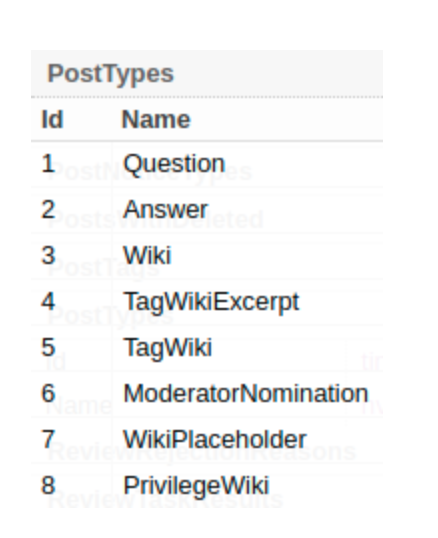

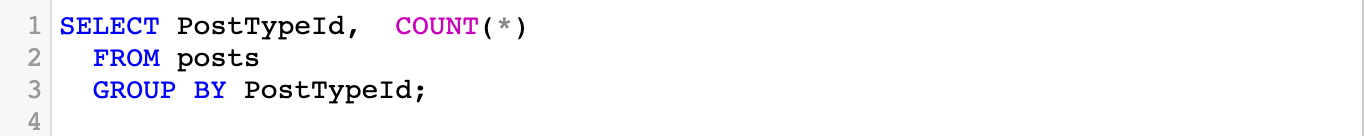

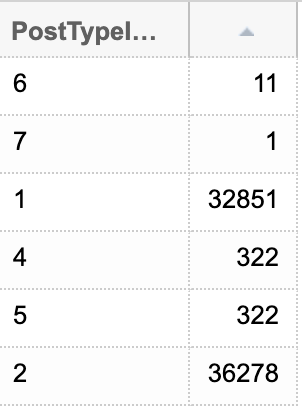

#### The following query is used to select the relevant columns for all questions posted in 2021 (it's mid 2022 at the time of writing). 
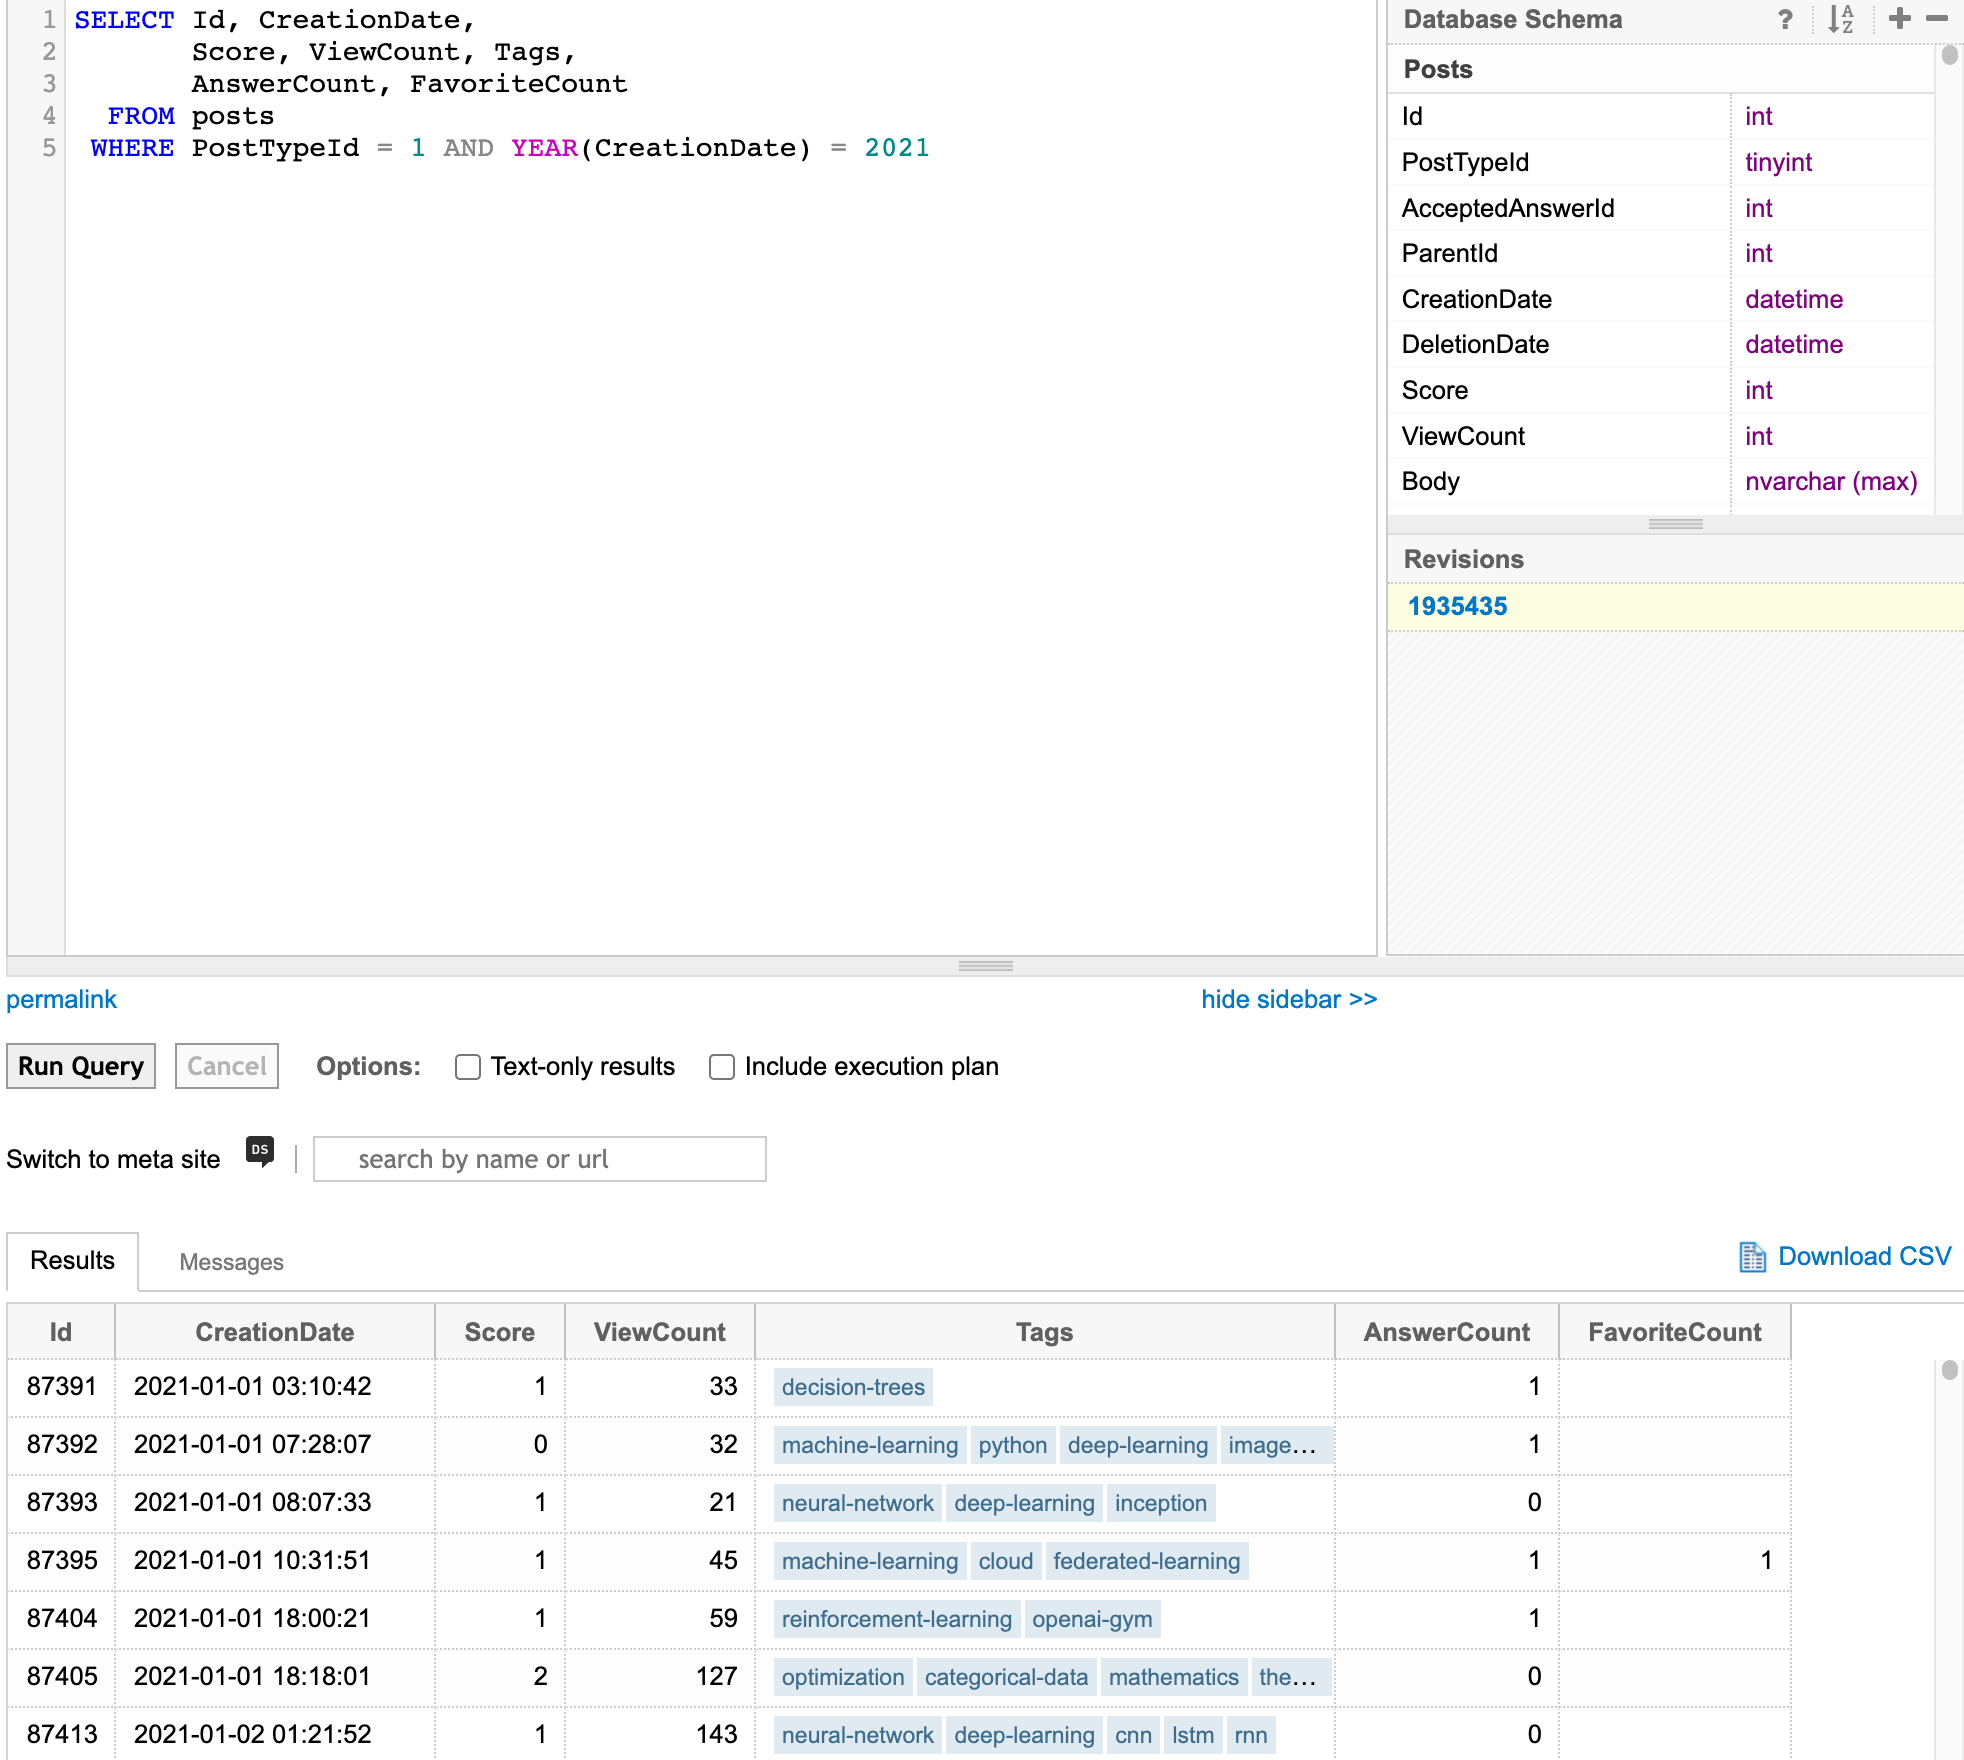




## Data Exploration 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [3]:
#read in data 
questions=pd.read_csv('2021_Questions.csv', parse_dates=['CreationDate'])
questions.head()

Id        CreationDate  Score  ViewCount  \
0  87391 2021-01-01 03:10:42      1         33   
1  87392 2021-01-01 07:28:07      0         30   
2  87393 2021-01-01 08:07:33      1         21   
3  87395 2021-01-01 10:31:51      1         45   
4  87404 2021-01-01 18:00:21      1         58   

                                                Tags  AnswerCount  \
0                                   <decision-trees>            1   
1  <machine-learning><python><deep-learning><imag...            1   
2         <neural-network><deep-learning><inception>            0   
3      <machine-learning><cloud><federated-learning>            1   
4               <reinforcement-learning><openai-gym>            1   

   FavoriteCount  
0            NaN  
1            NaN  
2            NaN  
3            1.0  
4            NaN

In [100]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6167 entries, 0 to 6166
Data columns (total 8 columns):
Id                6167 non-null int64
CreationDate      6167 non-null datetime64[ns]
Score             6167 non-null int64
ViewCount         6167 non-null int64
Tags              6167 non-null object
AnswerCount       6167 non-null int64
FavoriteCount     6167 non-null int64
length_of_tags    6167 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 385.6+ KB


In [6]:
questions.isnull().sum()/questions.shape[0]

Id               0.000000
CreationDate     0.000000
Score            0.000000
ViewCount        0.000000
Tags             0.000000
AnswerCount      0.000000
FavoriteCount    0.908221
dtype: float64

#### ~91% of the FavoriteCount column is missing. We can assume that a missing value just means the question was never favorited so we can replace the missing values with a 0. 

In [7]:
questions["FavoriteCount"] = questions["FavoriteCount"].fillna(0).astype(int)

#### To make analysis easier, we can clean up the Tags column to create a list of tags without the angle brackets. 

In [8]:
# clean the tags column into a list of comma-separated values
questions["Tags"] = (questions["Tags"].str.replace(r'^<|>$', "") # strip first and last angle brackets
                                      .str.split("><") # split string on '><' to separate all the tags in the list
                    )

In [9]:
# Check to ensure Tags column is cleaned. 
questions['Tags'][0:5]

0                                     [decision-trees]
1    [machine-learning, python, deep-learning, imag...
2           [neural-network, deep-learning, inception]
3        [machine-learning, cloud, federated-learning]
4                 [reinforcement-learning, openai-gym]
Name: Tags, dtype: object

#### Look into the amount of times a tag is used and viewed:

In [171]:
## count the number of times a tag is used 
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
            
## convert the dictionary with the counts for each Tag into a dataframe 
tag_used_count = pd.DataFrame(list(tag_count.items()),columns = ['Tags','Count'])

'There are {} unique tags for questions on the Data Science Exchange site in 2021'.format(tag_used_count.shape[0])

'There are 592 unique tags for questions on the Data Science Exchange site in 2021'

In [172]:
tag_used_count.head()

Tags  Count
0        decision-trees    126
1      machine-learning   1653
2                python   1144
3         deep-learning    892
4  image-classification    143

In [13]:
## sort the tags to see what the top 20 tags are
top_20_used_tags=tag_used_count.sort_values(by='Count').tail(20)

In [14]:
top_20_used_tags

Tags  Count
97                     statistics    185
41         machine-learning-model    185
210  convolutional-neural-network    188
18                           lstm    196
30                     clustering    197
121                       pytorch    208
68                         pandas    210
23                     regression    229
37                        dataset    252
17                            cnn    260
33                   scikit-learn    359
115                   time-series    369
44                     tensorflow    475
43                          keras    487
47                 classification    501
57                            nlp    527
6                  neural-network    564
3                   deep-learning    892
2                          python   1144
1                machine-learning   1653

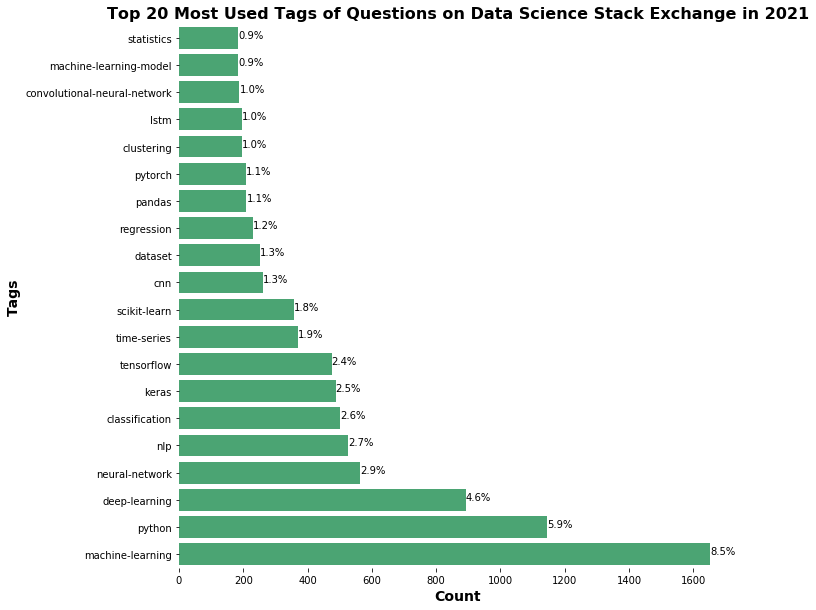

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10,10))

ax = sns.barplot(x='Count',y="Tags", data=top_20_used_tags, color='mediumseagreen')
plt.title('Top 20 Most Used Tags of Questions on Data Science Stack Exchange in 2021', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Tags', fontsize=14, fontweight='bold')

total = sum(tag_used_count['Count'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)

plt.show()


In [175]:
## Create a dictionary with the number of views for each tag
tag_view_count=dict()
for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else: 
            tag_view_count[tag] = row['ViewCount']
            
## Convert the dictionary to a dataframe 
tag_view_count = pd.DataFrame(list(tag_view_count.items()),columns = ['Tags','View_Count'])

## Select top 20 most viewed tags 
top_20_viewed_tags = tag_view_count.sort_values(by="View_Count").tail(20)
top_20_viewed_tags

Tags  View_Count
4            image-classification       23532
37                        dataset       27879
99                           bert       30516
115                   time-series       31393
121                       pytorch       32649
75                    transformer       33243
210  convolutional-neural-network       33411
28                     matplotlib       35952
47                 classification       41774
17                            cnn       43491
45                          numpy       45837
6                  neural-network       49326
57                            nlp       56200
33                   scikit-learn       68941
68                         pandas       72270
44                     tensorflow       85651
43                          keras       85934
3                   deep-learning      102689
1                machine-learning      149635
2                          python      215311

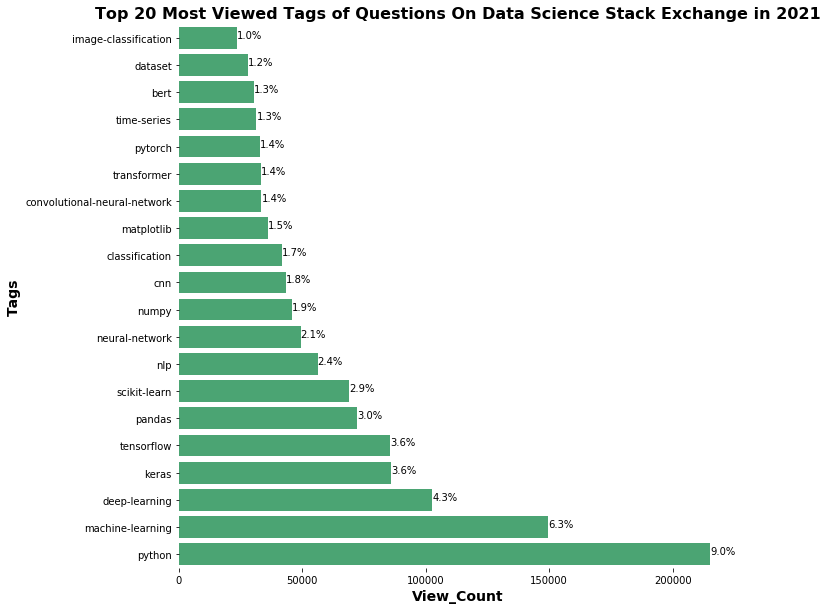

In [180]:
plt.figure(figsize=(10,10))
ax=sns.barplot(x='View_Count', y='Tags', data=top_20_viewed_tags, color='mediumseagreen')


plt.title('Top 20 Most Viewed Tags of Questions On Data Science Stack Exchange in 2021', fontsize=16, fontweight='bold')
plt.xlabel('View_Count', fontsize=14, fontweight='bold')
plt.ylabel('Tags', fontsize=14, fontweight='bold')

total = sum(tag_view_count['View_Count'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)
    
plt.show()

In [181]:
in_used = pd.merge(top_20_used_tags, top_20_viewed_tags, how="left", left_index=True, right_index=True)
in_used

Tags_x  Count                        Tags_y  \
97                     statistics    185                           NaN   
41         machine-learning-model    185                           NaN   
210  convolutional-neural-network    188  convolutional-neural-network   
18                           lstm    196                           NaN   
30                     clustering    197                           NaN   
121                       pytorch    208                       pytorch   
68                         pandas    210                        pandas   
23                     regression    229                           NaN   
37                        dataset    252                       dataset   
17                            cnn    260                           cnn   
33                   scikit-learn    359                  scikit-learn   
115                   time-series    369                   time-series   
44                     tensorflow    475                    tensorflow   
43                          keras    487                         keras   
47                 classification    501                classification   
57                            nlp    527                           nlp   
6                  neural-network    564                neural-network   
3                   deep-learning    892                 deep-learning   
2                          python   1144                        python   
1                machine-learning   1653              machine-learning   

     View_Count  
97          NaN  
41          NaN  
210     33411.0  
18          NaN  
30          NaN  
121     32649.0  
68      72270.0  
23          NaN  
37      27879.0  
17      43491.0  
33      68941.0  
115     31393.0  
44      85651.0  
43      85934.0  
47      41774.0  
57      56200.0  
6       49326.0  
3      102689.0  
2      215311.0  
1      149635.0

#### "Machine Learning model", "Statistics", "lstm", "clustering", and "regression" are in the top 20 used tags but are not amongst the top 20 viewed tags 

In [182]:
in_viewed = pd.merge(top_20_used_tags, top_20_viewed_tags, how="right", left_index=True, right_index=True)
in_viewed

Tags_x   Count                        Tags_y  \
4                             NaN     NaN          image-classification   
37                        dataset   252.0                       dataset   
99                            NaN     NaN                          bert   
115                   time-series   369.0                   time-series   
121                       pytorch   208.0                       pytorch   
75                            NaN     NaN                   transformer   
210  convolutional-neural-network   188.0  convolutional-neural-network   
28                            NaN     NaN                    matplotlib   
47                 classification   501.0                classification   
17                            cnn   260.0                           cnn   
45                            NaN     NaN                         numpy   
6                  neural-network   564.0                neural-network   
57                            nlp   527.0                           nlp   
33                   scikit-learn   359.0                  scikit-learn   
68                         pandas   210.0                        pandas   
44                     tensorflow   475.0                    tensorflow   
43                          keras   487.0                         keras   
3                   deep-learning   892.0                 deep-learning   
1                machine-learning  1653.0              machine-learning   
2                          python  1144.0                        python   

     View_Count  
4         23532  
37        27879  
99        30516  
115       31393  
121       32649  
75        33243  
210       33411  
28        35952  
47        41774  
17        43491  
45        45837  
6         49326  
57        56200  
33        68941  
68        72270  
44        85651  
43        85934  
3        102689  
1        149635  
2        215311

#### "image-classification", "bert", "transformer", and "matplotlib" are in the top 20 viewed tags but are not amongst the top 20 used tags


#### Look into how many tags a question typically has:

In [25]:
questions['length_of_tags']=questions['Tags'].apply(lambda x: len(x))

In [26]:
questions['length_of_tags'].value_counts()/len(questions)

3    0.274850
2    0.216475
4    0.210962
5    0.190855
1    0.106859
Name: length_of_tags, dtype: float64

#### Looking at the tags individually does not paint as clear of picture as we would like. Each question has multiple tags associated with it. For example a question inquring about a naive bayes classifier inlcudes the tags "classification", "python", and "pandas". As seen above, ~22% of the questions have atleast 2 tags, and ~67% of the questions have atleast 3 tags or more. How can we capture the relationship between tags to get a more informative picture of what the most popular topics of 2020 are? 

#### Let's take a look at what pairs of tags appear the most:

In [91]:
## Create flat list of all the tags
list_of_tags=[item for tag in questions['Tags'] for item in tag]
## Create a dataframe using the flat list 
df_tags = pd.DataFrame (list_of_tags, columns = ['tag_name'])
## Find all possible combinations of pairs of tags
df_tag_combinations = pd.DataFrame({'combination': list(itertools.combinations(df_tags.tag_name, 2))})

In [94]:
df_tag_combinations.head()

combination
0      (decision-trees, machine-learning)
1                (decision-trees, python)
2         (decision-trees, deep-learning)
3  (decision-trees, image-classification)
4   (decision-trees, image-preprocessing)

In [102]:
len(df_tag_combinations)

190173753

#### We will focus on pairs that include the top 20 *most used* Tags 

In [106]:
## Create a list of all the tags to be selected from the massive list of combinations.
selection=top_20_used_tags.Tags.tolist()

In [112]:
## The code below creates a list of the combination column in the df_tag_combinations dataframe. The list is then 
## converted to a dataframe with two columns, one for each element in the combination column. The dataframe is then 
## checked for any matches of the 
df_tag_combinations[pd.DataFrame(df_tag_combinations.combination.tolist()).isin(selection).any(1).values]

combination  number of occurrences
0               (decision-trees, machine-learning)                   31.0
1                         (decision-trees, python)                   19.0
2                  (decision-trees, deep-learning)                    1.0
5                 (decision-trees, neural-network)                    6.0
6                  (decision-trees, deep-learning)                    1.0
...                                            ...                    ...
190173747        (cost-function, machine-learning)                    NaN
190173748          (cost-function, neural-network)                    NaN
190173750       (machine-learning, neural-network)                    NaN
190173751  (machine-learning, predictive-modeling)                    NaN
190173752    (neural-network, predictive-modeling)                    NaN

[135869922 rows x 2 columns]

#### The combination column has a number of rows that are not needed. First off, all rows with NaN's in the *number of occurrences* column have to be removed; these are the rows that don't include a pair with atleast one of the top 20 most used tags. The *combination* column also inlcudes tuples that have identical elements (ex. (machine-learning, machine-learning)) that are not relevant to our analysis. All duplicates also need to be removed. Duplicates include all tuples that include the same elements but in reverse order (ex. (decision-trees, python) and (python, decision-trees), and multiple instances of the same tuple (present as a result of the way the above dataframe was constructed). 

In [113]:
## Drop all rows where the number of occurrences column has a NaN, as that means the tags are not amongst the top 20 
## most used tags. 
df_tag_combinations_match=df_tag_combinations.dropna()

In [131]:
## All combinations where a tag is paired with itself need to be removed. 
## Create a list of pairs that have identical elements 
combinations_to_remove=[]
for i in selection:
    combo=(i,i)
    combinations_to_remove.append(combo)
    
## Remove the pairs that have identical elements from the dataframe 
df_tag_combinations_match_updated=df_tag_combinations_match[~df_tag_combinations_match['combination'].isin(combinations_to_remove)]

In [145]:
## Duplicates also need to be removed. For example the tuple (deep-learning, machine-translation) and (machine-translation, deep-learning) are the same. 

# create a list of the elements of the combination column 
combinations_list=df_tag_combinations_match_updated.combination.tolist()

# sorting tuples
combinations_list_sorted = [tuple(sorted(sub)) for sub in combinations_list]
  
# removing duplicates
combinations_deduped = list(set(combinations_list_sorted))

# only keep what is in the set in the dataframe 
df_tag_combinations_match__dedupe=df_tag_combinations_match_updated[df_tag_combinations_match_updated['combination'].isin(combinations_deduped)]

In [153]:
## Remove all duplicates of the combination list in the set (created above), except first instance. 
df_tag_combinations_match_updated__dedupe_2=df_tag_combinations_match__dedupe.drop_duplicates(subset='combination', keep='first')

In [159]:
## Find top 30 pairs of most used tags 
df_tag_combo_top30=df_tag_combinations_match_updated__dedupe_2.sort_values(by='number of occurrences').tail(30)

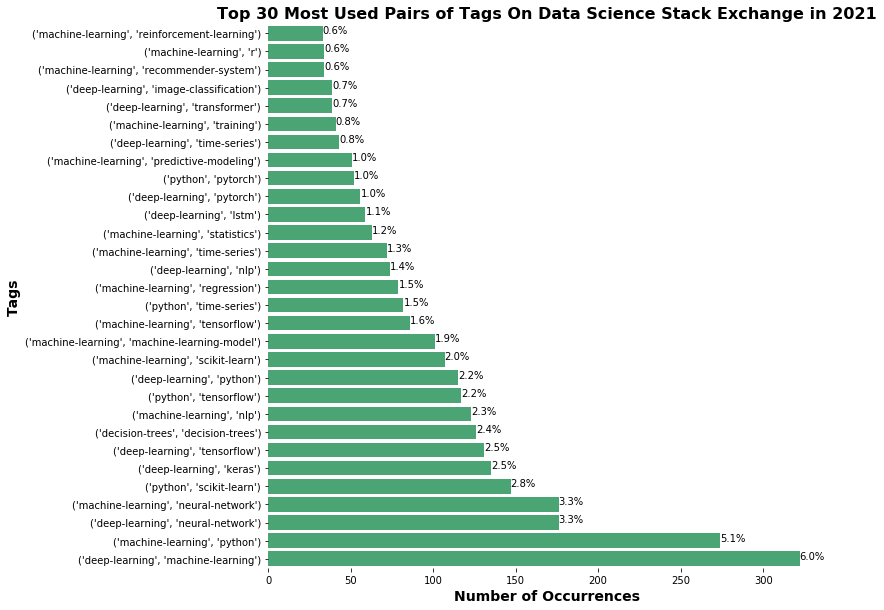

In [186]:
plt.figure(figsize=(10,10))
ax=sns.barplot(x='number of occurrences', y='combination', data=df_tag_combo_top30, color='mediumseagreen')


plt.title('Top 30 Most Used Pairs of Tags On Data Science Stack Exchange in 2021', fontsize=16, fontweight='bold')
plt.xlabel('Number of Occurrences', fontsize=14, fontweight='bold')
plt.ylabel('Tags', fontsize=14, fontweight='bold')

total = sum(df_tag_combinations_match_updated__dedupe_2['number of occurrences'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)
    
plt.show()


#### The machine-learning tag is often used with deep-learning or a tag related to deep-learning. Roughly ~55.4% of the pairs include a term related to deep-learning. Is deep-learning currently the most popular topic within data science? This is explored further below.  

### Is Deep-Learning a Fad? 

#### To explore whether deep-learning is just a fad, let's first get the data of all questions on Stack Exchange till date. 
#### Edit the previous query to include all years:
#### *SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount FROM posts WHERE PostTypeId = 1;*



In [190]:
all_questions=pd.read_csv('all_questions_updated.csv', parse_dates=['CreationDate'])

In [191]:
all_questions.head()

Id        CreationDate  Score  ViewCount  \
0  30167 2018-04-11 11:43:24      5         79   
1  30170 2018-04-11 13:32:31      4        309   
2  30171 2018-04-11 14:20:40      1         21   
3  30175 2018-04-11 15:34:05      3       3117   
4  30176 2018-04-11 15:38:16      5       1737   

                                                Tags  AnswerCount  \
0  <machine-learning><classification><time-series...            0   
1  <neural-network><classification><keras><evalua...            1   
2                  <data-mining><data-stream-mining>            0   
3                                <keras><tensorflow>            2   
4  <machine-learning><scikit-learn><bigdata><algo...            2   

   FavoriteCount  
0            2.0  
1            2.0  
2            NaN  
3            5.0  
4            1.0

In [192]:
## Clean Tags column
all_questions["Tags"] = (all_questions["Tags"].str.replace(r'^<|>$', "") # strip first and last angle brackets
                                      .str.split("><") # split string on '><' to separate all the tags in the list
                    )

In [193]:
all_questions['Tags'].sample(3)

3225                                         [clustering]
4684    [data-mining, visualization, graphs, graphical...
9580      [keras, convolutional-neural-network, metadata]
Name: Tags, dtype: object

In [194]:
#Select deep learning related tags. Based on the top20 most used tag
#lstm, cnn, tensorflow, keras, neural-network, deep-learning fall into the "deep-Learning
#related" category. 

def label_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "convolutional-nerual-network", "tensorflow",
                   "keras", "neural-network", "deep-learning", 'pytorch']:
            return 1
    return 0



In [195]:
all_questions['deep_learning_tag']=all_questions['Tags'].apply(label_deep_learning)

In [196]:
all_questions.head(5)

Id        CreationDate  Score  ViewCount  \
0  30167 2018-04-11 11:43:24      5         79   
1  30170 2018-04-11 13:32:31      4        309   
2  30171 2018-04-11 14:20:40      1         21   
3  30175 2018-04-11 15:34:05      3       3117   
4  30176 2018-04-11 15:38:16      5       1737   

                                                Tags  AnswerCount  \
0  [machine-learning, classification, time-series...            0   
1  [neural-network, classification, keras, evalua...            1   
2                  [data-mining, data-stream-mining]            0   
3                                [keras, tensorflow]            2   
4  [machine-learning, scikit-learn, bigdata, algo...            2   

   FavoriteCount  deep_learning_tag  
0            2.0                  0  
1            2.0                  1  
2            NaN                  0  
3            5.0                  1  
4            1.0                  0

In [197]:
## Filter out all_questions such that all years 2021 and earlier are included. Did not include 2022 as it is not yet complete. 
all_questions = all_questions[all_questions["CreationDate"].dt.year <= 2021]

#### Data Science space isn't as dynamic enough to track daily, weekly, or monthly changes. Therefore, we will look at the percent of deep-learning questions per quarter. 

In [198]:
## use PeriodIndex function to get date by quarter and year
all_questions["quarter"] = pd.PeriodIndex(all_questions["CreationDate"], freq='Q')
## add a year column 
all_questions['year']=all_questions['CreationDate'].dt.year

In [199]:
all_questions.head(2)

Id        CreationDate  Score  ViewCount  \
0  30167 2018-04-11 11:43:24      5         79   
1  30170 2018-04-11 13:32:31      4        309   

                                                Tags  AnswerCount  \
0  [machine-learning, classification, time-series...            0   
1  [neural-network, classification, keras, evalua...            1   

   FavoriteCount  deep_learning_tag quarter  year  
0            2.0                  0  2018Q2  2018  
1            2.0                  1  2018Q2  2018

In [200]:
## all quarters for 2014 aren't present
all_questions_sub=all_questions[all_questions['year']>2014]

In [201]:
all_questions_sub.year.value_counts()

2019    6758
2021    6167
2020    6151
2018    5327
2017    2917
2016    2113
2015    1161
Name: year, dtype: int64

#### Determine: 
1. How many total questions there are for a given quarter within a given year?
2. How many deep learning questions are there for a given quarter in a given year?
3. Calculate the percentage of deep learning questions for a given quarter in a given year

In [202]:
## Group by *quarter* column and find the total number of deep learning questions (sum) per quarter 
## and total number of questions per quarter (size). 
per_year_per_quarter=all_questions_sub.groupby('quarter').agg({"deep_learning_tag": ['sum', 'size']})

## Name columns 
per_year_per_quarter.columns=['q_deeplearning', 'q_total']

## Calculate the percentage of deep learning questions per quarter 
per_year_per_quarter['q_percentage']= per_year_per_quarter['q_deeplearning']/per_year_per_quarter['q_total']

## Reset index so that the quarter is not an index but column 
per_year_per_quarter.reset_index(inplace=True)

## Display first 5 rows 
per_year_per_quarter.head(5)

quarter  q_deeplearning  q_total  q_percentage
0  2015Q1              13      188      0.069149
1  2015Q2              20      284      0.070423
2  2015Q3              28      310      0.090323
3  2015Q4              52      379      0.137203
4  2016Q1              79      510      0.154902

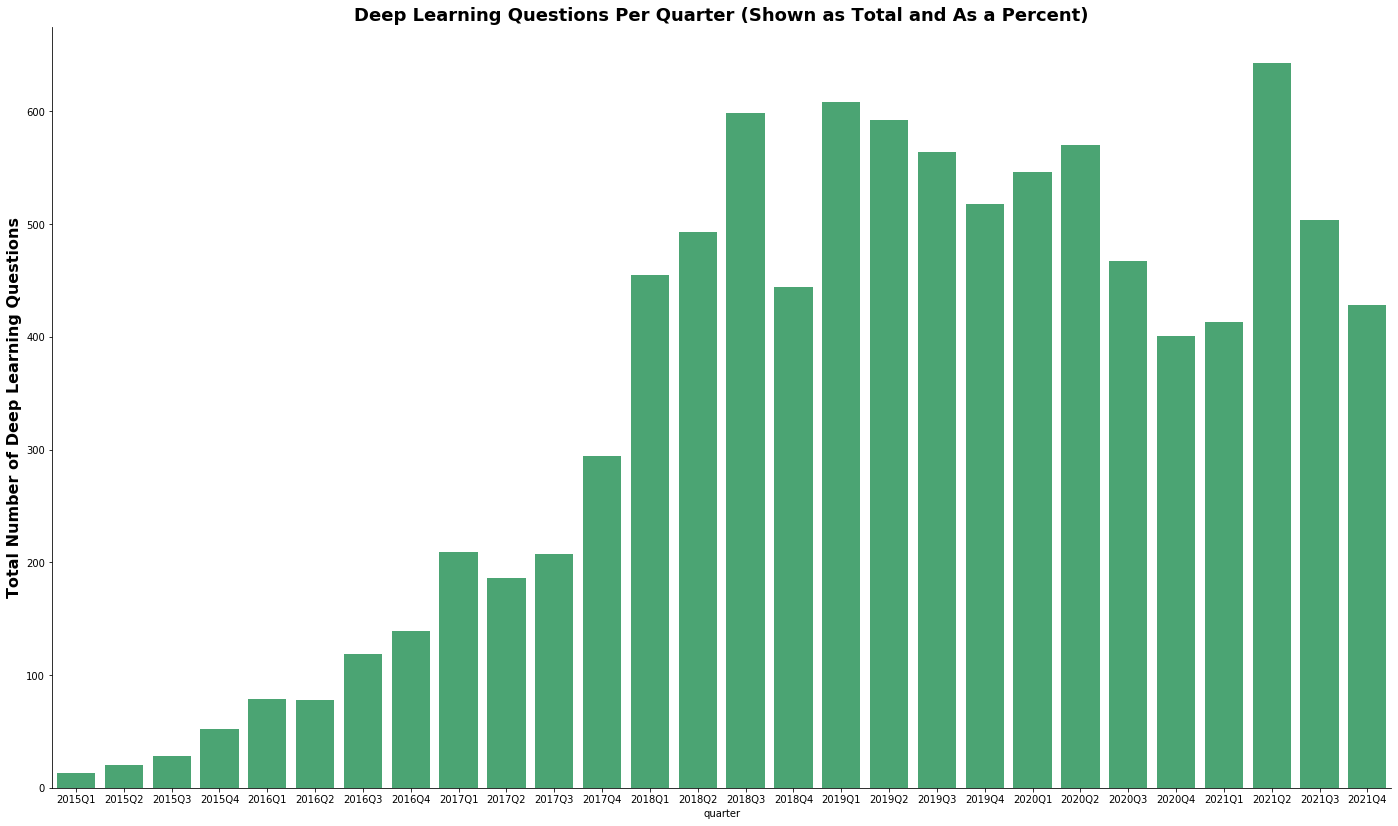

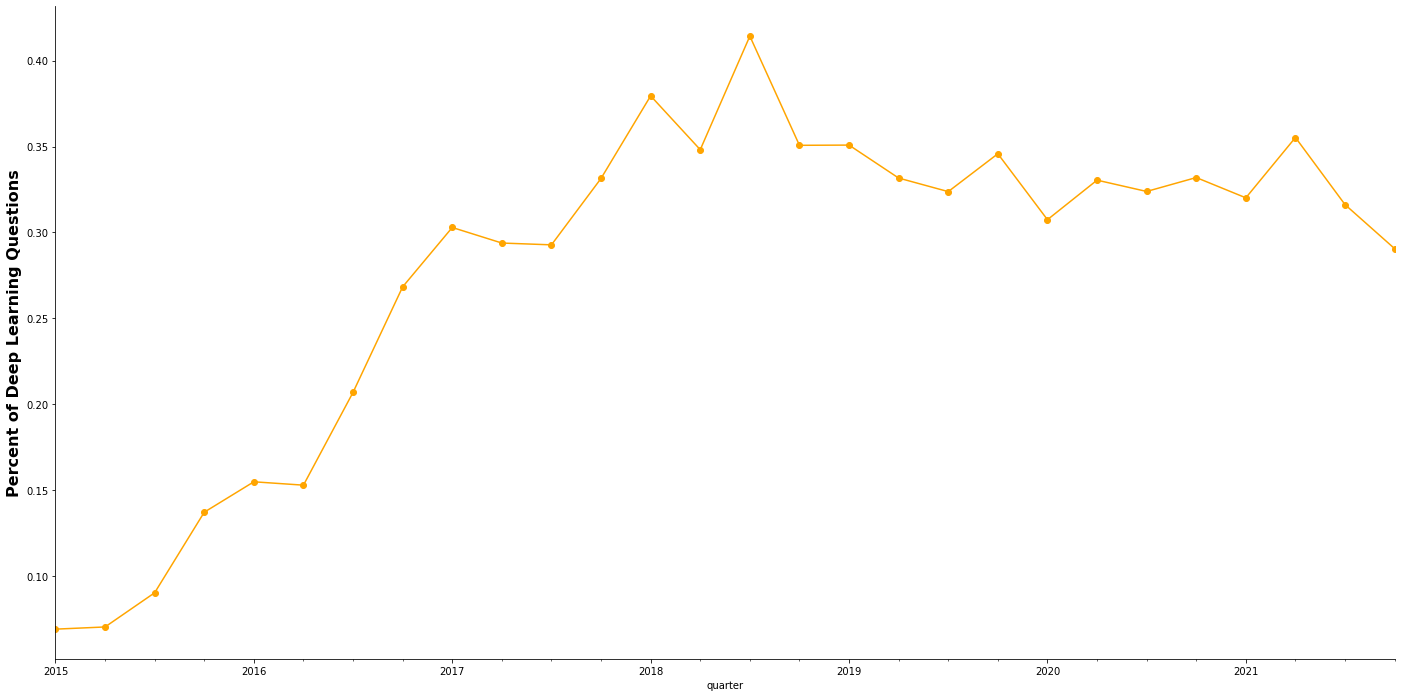

In [225]:
plt.figure(figsize=(24,14))

ax=sns.barplot(x='quarter', y='q_deeplearning', data=per_year_per_quarter, color='mediumseagreen')
ax.set_title('Deep Learning Questions Per Quarter (Shown as Total and As a Percent)', fontweight='bold', fontsize=18)
ax.set_ylabel('Total Number of Deep Learning Questions', fontweight='bold', fontsize=16)


ax1 = per_year_per_quarter.plot(x="quarter", y="q_percentage",
                    kind="line", linestyle="-", marker="o", color="orange", legend=False, 
                    figsize=(24,12)
                    )
ax1.set_ylabel('Percent of Deep Learning Questions', fontweight='bold', fontsize=16)

for ax in (ax, ax1):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)



In [203]:
## Create a dataframe as the one above but yearly, rather than qaurterly  
per_year=all_questions_sub.groupby('year').agg({"deep_learning_tag": ['sum', 'size']})
per_year.columns=['q_deeplearning', 'q_total']
per_year['q_dl_percentage']=per_year['q_deeplearning']/per_year['q_total']
per_year['q_other']=per_year['q_total']-per_year['q_deeplearning']
per_year['q_other_percentage']=per_year['q_other']/per_year['q_total']
per_year.head(5)

q_deeplearning  q_total  q_dl_percentage  q_other  q_other_percentage
year                                                                       
2015             113     1161         0.097330     1048            0.902670
2016             415     2113         0.196403     1698            0.803597
2017             896     2917         0.307165     2021            0.692835
2018            1991     5327         0.373756     3336            0.626244
2019            2282     6758         0.337674     4476            0.662326

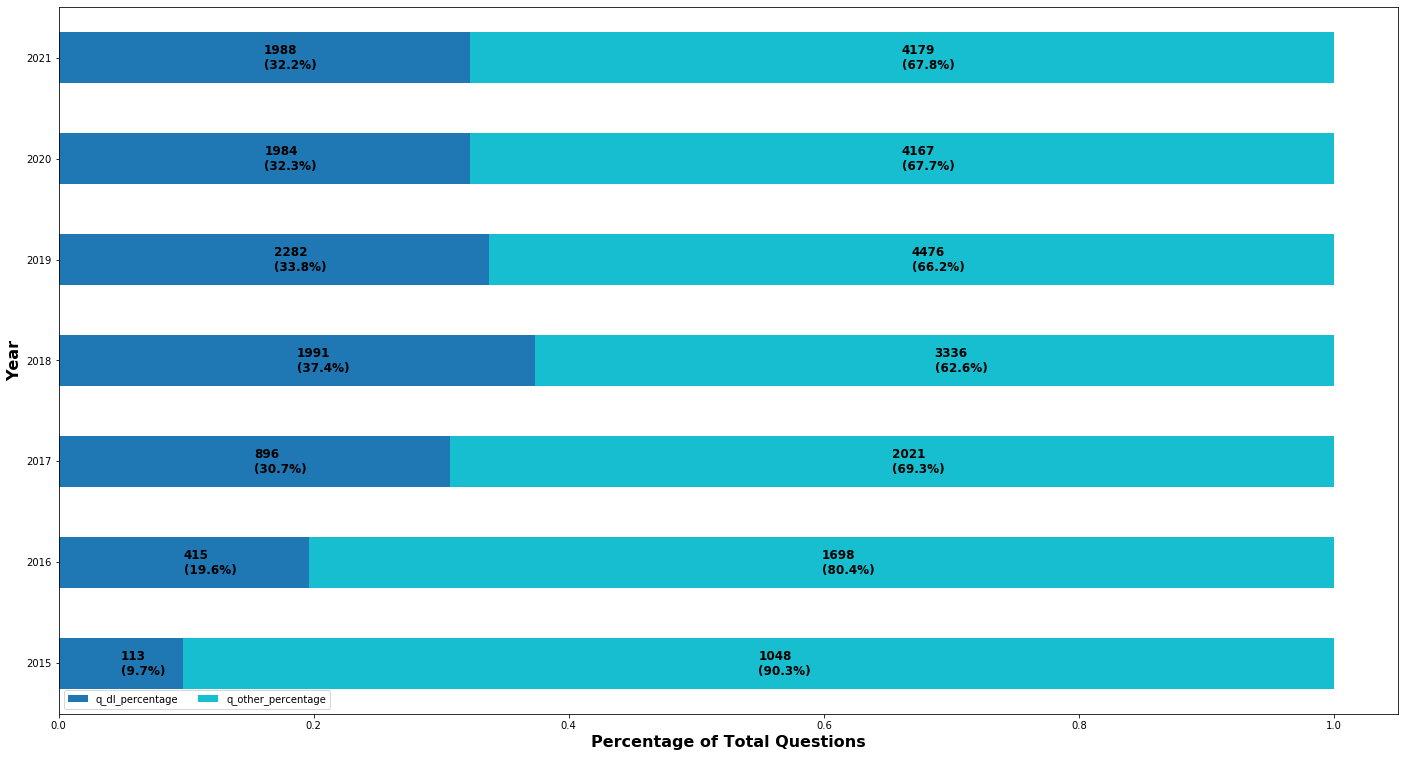

In [226]:
per_year_prop=per_year[['q_dl_percentage', 'q_other_percentage']]
per_year_count=per_year[['q_deeplearning', 'q_other']]

per_year_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(24, 13))

plt.legend(loc="lower left", ncol=2)
plt.ylabel("Year", fontsize='16', fontweight='bold')
plt.xlabel("Percentage of Total Questions", fontsize='16', fontweight='bold')


for n, x in enumerate([*per_year_count.index.values]):
    for (proportion, count, y_loc) in zip(per_year_prop.loc[x],
                                          per_year_count.loc[x],
                                          per_year_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        
for location in ['right', 'top']:
    ax.spines[location].set_visible(False)


plt.show()

In [228]:
from wordcloud import WordCloud

In [229]:
def make_word_cloud(year):
    df_dict={}
    df_name='questions_'+str(year)
    df_dict[df_name]=all_questions[all_questions['year']==y]  

In [230]:
df_dict={}
year_list=[2015, 2016, 2017, 2018, 2019, 2020, 2021]
for y in year_list:
    df_name='questions_'+str(y)
    df_dict[df_name]= all_questions[all_questions['year']==y]  

In [231]:
flat_list_of_tags=[]
for name, df in df_dict.items():
    flat_list_of_tags.append([item for sublist in df['Tags'] for item in sublist])
    

In [232]:
tags_flattened_items_joined=[(" ").join(flat_list_of_tags[i]) for i in range(len(flat_list_of_tags))]

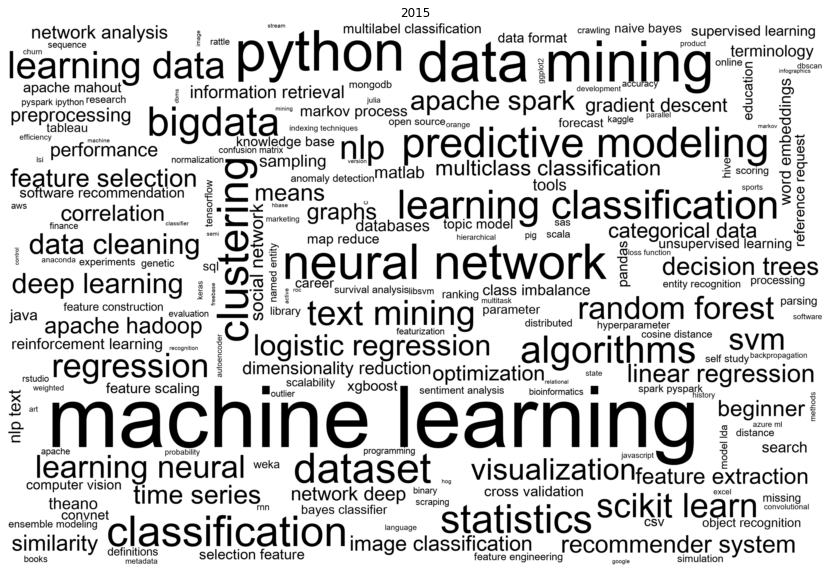

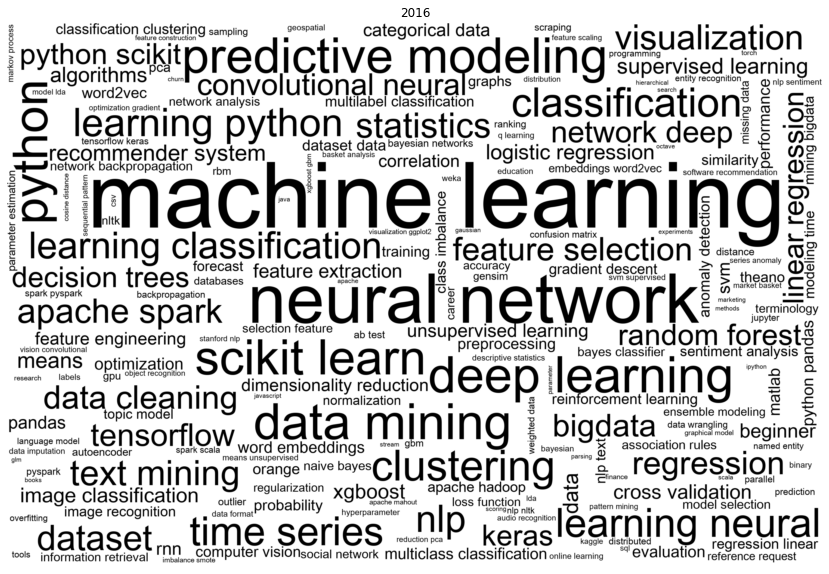

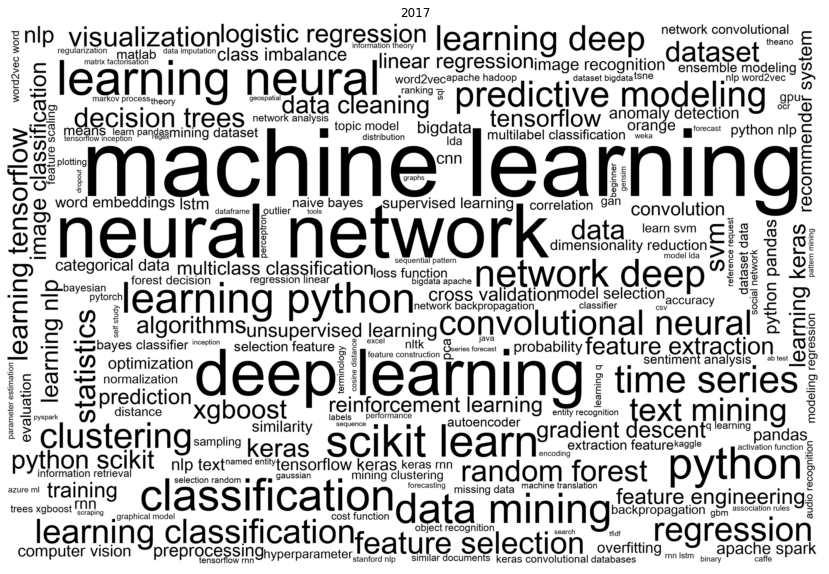

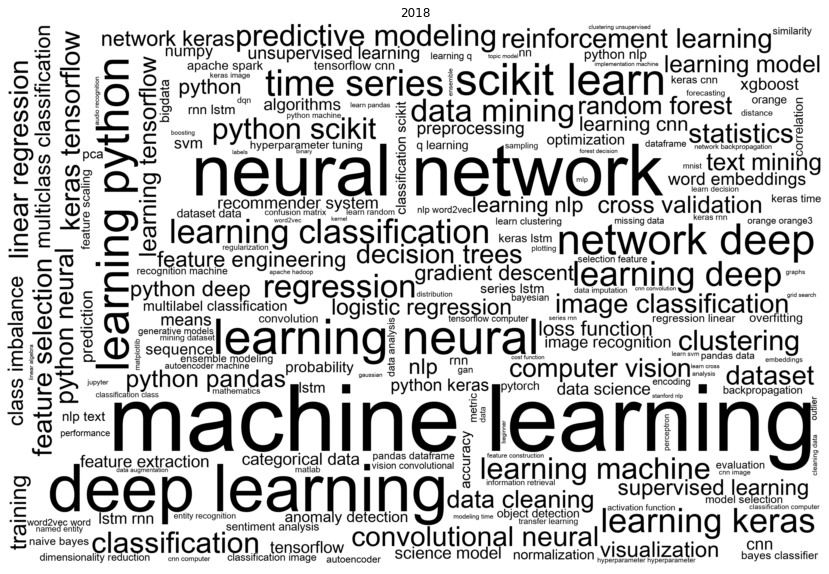

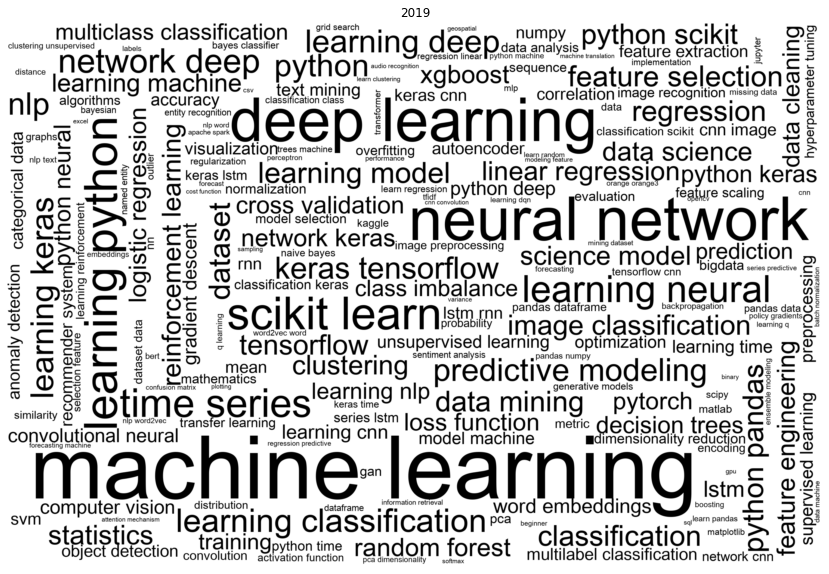

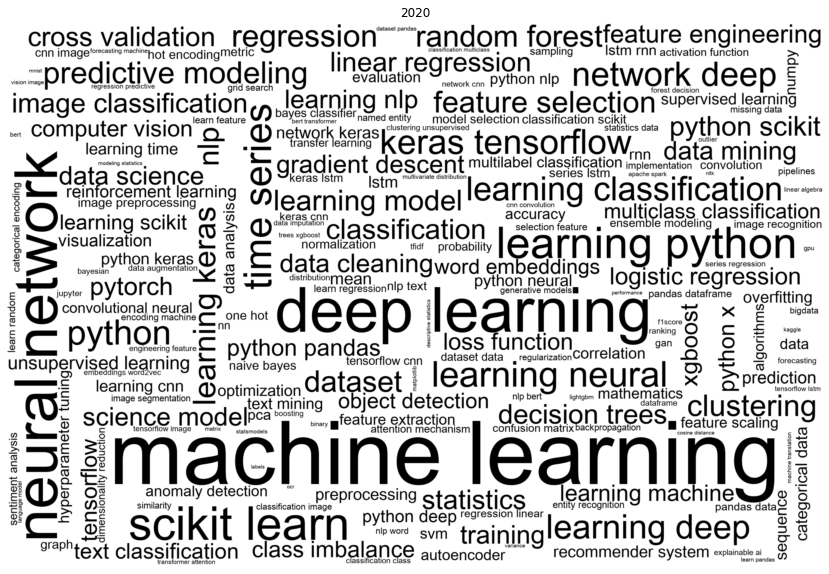

In [65]:
for i, j in zip(range(len(tags_flattened_items_joined)), range(2015,2021)):
    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=200, color_func=lambda *args, **kwargs: (0,0,0) ).generate(tags_flattened_items_joined[i])
    # set the word color to black
    #wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[15,10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")
    plt.title(str(j))
    # save the image
    #plt.savefig('biden_wc.png')

#### Over the years, the tags deep learning, keras, and tensorflow have become more popular, so perhaps the next "best" thing to write a post on is a deep-learning related topic. 